# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

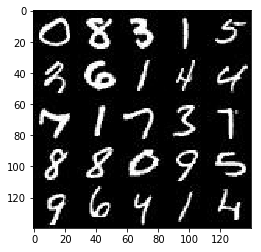

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

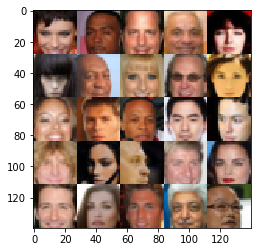

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/andrzej/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [74]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/andrzej/.conda/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/andrzej/.conda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/andrzej/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/andrzej/.conda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/andrzej/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', '

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.01*layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(0.01*batch_norm2, batch_norm2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(0.01*batch_norm3, batch_norm3)
        
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    reuse = not is_train
    
    with(tf.variable_scope('generator', reuse=reuse)):
        
        layer1 = tf.layers.dense(z, 4*4*512)
        layer1 = tf.reshape(layer1, (-1, 4, 4, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(0.01*layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(0.01*layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(0.01*layer3, layer3)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28,28))
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [53]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()

    def get_vars_prefixed(variables, prefix):
        new_vars = []
        for variable in variables:
            if(variable.name[0:len(prefix)] == prefix):
                new_vars.append(variable)
        return new_vars

    g_vars = get_vars_prefixed(t_vars, 'generator')
    d_vars = get_vars_prefixed(t_vars, 'discriminator')

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [84]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver(var_list = g_vars)

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    
    if(data_image_mode == 'RGB'):
        input_channels = 3
    else:
        input_channels = 1
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], input_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, input_channels)
        
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 1, input_z, input_channels, data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')
    with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.9057... Generator Loss: 0.0010


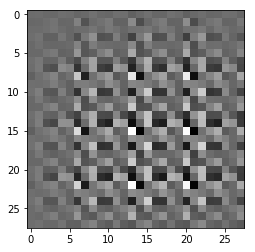

Epoch 1/2... Discriminator Loss: 0.3076... Generator Loss: 19.4612


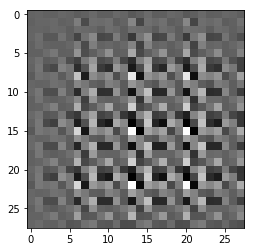

Epoch 1/2... Discriminator Loss: 0.0207... Generator Loss: 19.3450


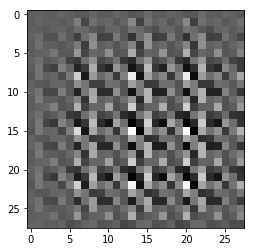

Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 13.9290


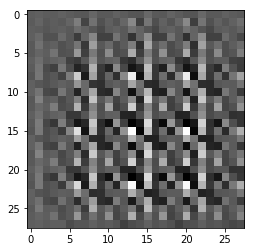

Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 7.2755


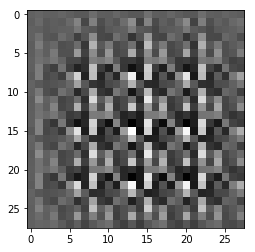

Epoch 1/2... Discriminator Loss: 0.0709... Generator Loss: 2.7046


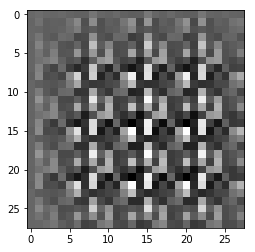

Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 8.7132


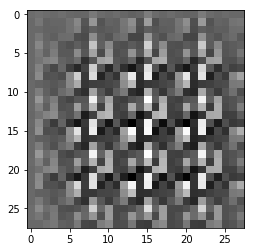

Epoch 1/2... Discriminator Loss: 0.0297... Generator Loss: 3.6568


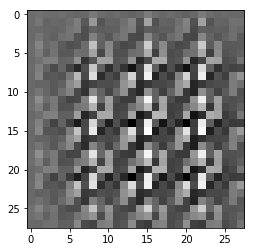

Epoch 1/2... Discriminator Loss: 0.0250... Generator Loss: 4.3781


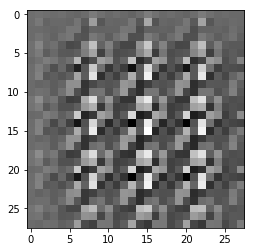

Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 3.8384


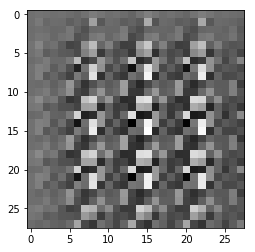

Epoch 1/2... Discriminator Loss: 0.1418... Generator Loss: 2.3111


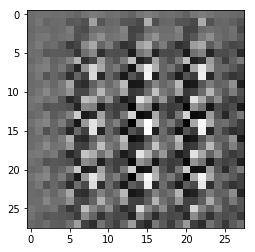

Epoch 1/2... Discriminator Loss: 0.7030... Generator Loss: 14.3617


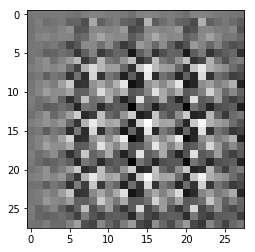

Epoch 1/2... Discriminator Loss: 17.7934... Generator Loss: 0.0000


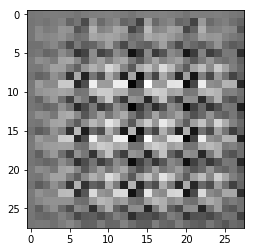

Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 8.7903


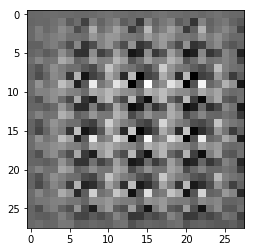

Epoch 1/2... Discriminator Loss: 0.6430... Generator Loss: 1.4874


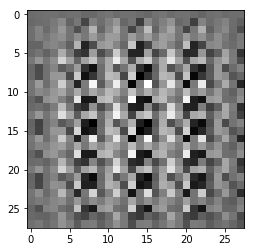

Epoch 1/2... Discriminator Loss: 3.8246... Generator Loss: 0.0270


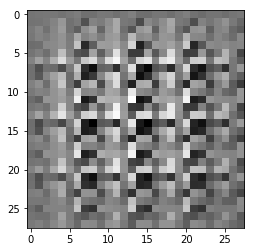

Epoch 1/2... Discriminator Loss: 6.1396... Generator Loss: 19.2583


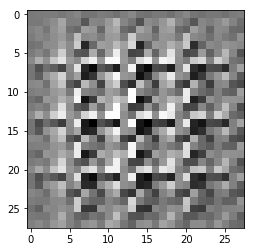

Epoch 1/2... Discriminator Loss: 0.0976... Generator Loss: 13.9448


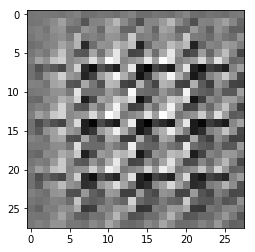

Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 0.6608


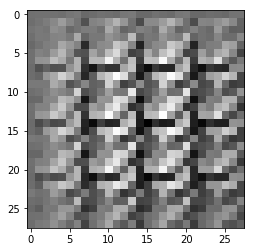

Epoch 1/2... Discriminator Loss: 0.0960... Generator Loss: 3.5933


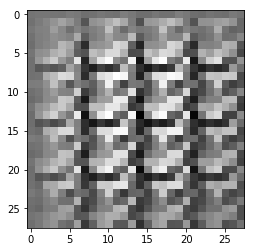

Epoch 1/2... Discriminator Loss: 0.2482... Generator Loss: 2.4074


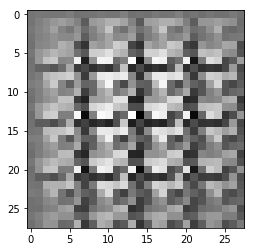

Epoch 1/2... Discriminator Loss: 0.5019... Generator Loss: 1.4126


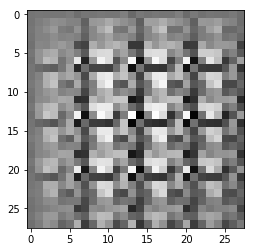

Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 4.5198


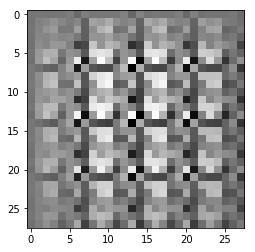

Epoch 1/2... Discriminator Loss: 2.2774... Generator Loss: 0.1663


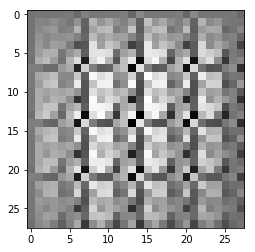

Epoch 1/2... Discriminator Loss: 2.8892... Generator Loss: 14.2333


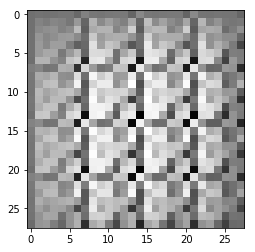

Epoch 1/2... Discriminator Loss: 0.2132... Generator Loss: 6.2664


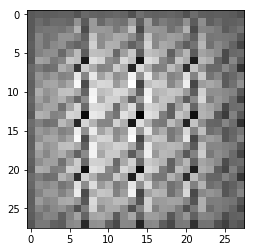

Epoch 1/2... Discriminator Loss: 4.6594... Generator Loss: 0.0910


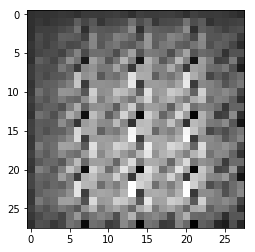

Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 6.8636


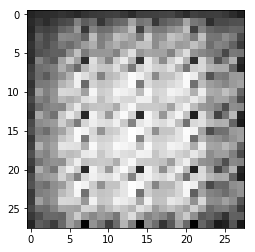

Epoch 1/2... Discriminator Loss: 0.6850... Generator Loss: 6.6071


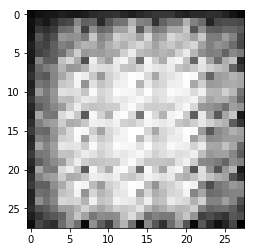

Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.7798


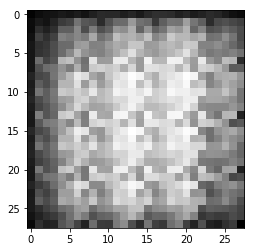

Epoch 1/2... Discriminator Loss: 1.6219... Generator Loss: 1.3388


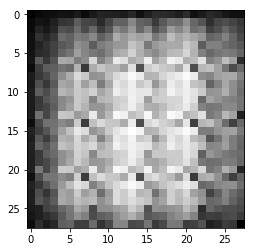

Epoch 1/2... Discriminator Loss: 1.2357... Generator Loss: 4.0948


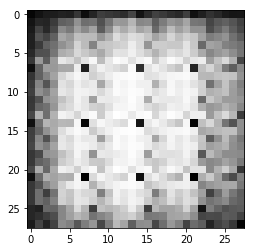

Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.0872


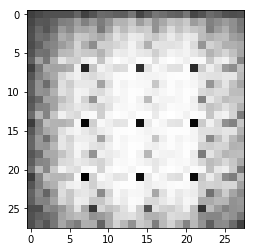

Epoch 1/2... Discriminator Loss: 0.5985... Generator Loss: 4.4520


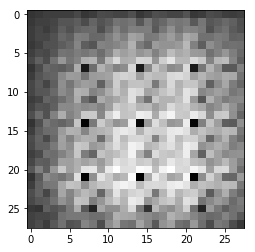

Epoch 1/2... Discriminator Loss: 0.1917... Generator Loss: 3.8722


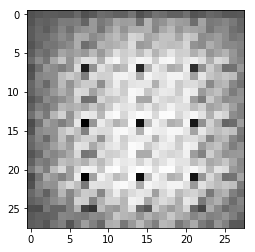

Epoch 1/2... Discriminator Loss: 0.3640... Generator Loss: 1.7042


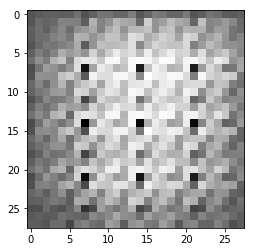

Epoch 1/2... Discriminator Loss: 0.3206... Generator Loss: 2.0681


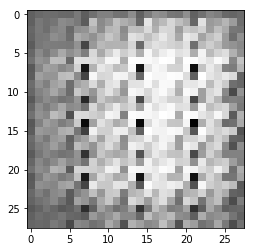

Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 1.6670


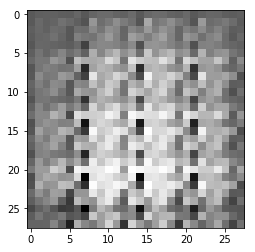

Epoch 1/2... Discriminator Loss: 0.4715... Generator Loss: 1.6571


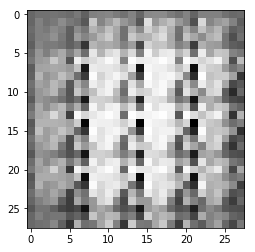

Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 2.6599


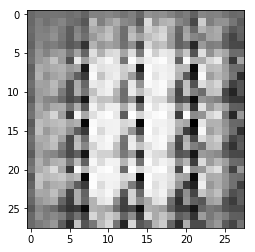

Epoch 1/2... Discriminator Loss: 0.2220... Generator Loss: 2.2518


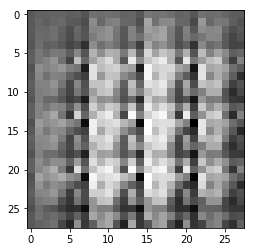

Epoch 1/2... Discriminator Loss: 0.1949... Generator Loss: 2.3570


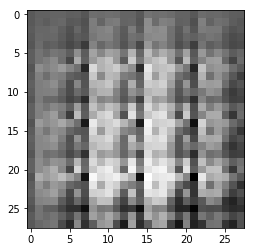

Epoch 1/2... Discriminator Loss: 0.1875... Generator Loss: 2.4648


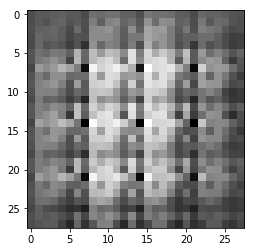

Epoch 1/2... Discriminator Loss: 0.3101... Generator Loss: 1.8307


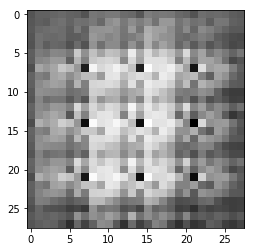

Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 3.1973


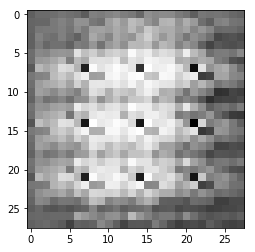

Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.3030


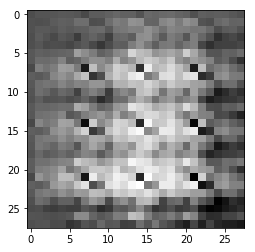

Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 9.6266


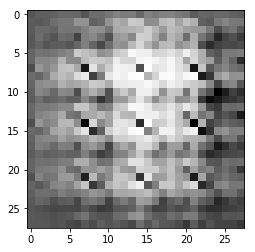

Epoch 1/2... Discriminator Loss: 0.2559... Generator Loss: 1.9370


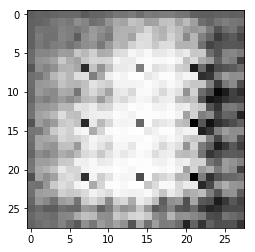

Epoch 1/2... Discriminator Loss: 2.6307... Generator Loss: 0.1970


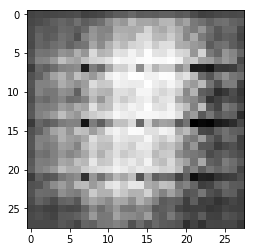

Epoch 1/2... Discriminator Loss: 3.9768... Generator Loss: 10.2699


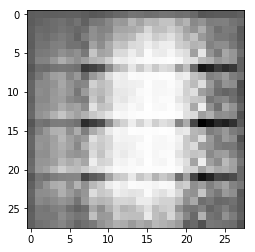

Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 5.1105


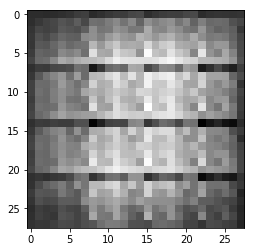

Epoch 1/2... Discriminator Loss: 1.7239... Generator Loss: 0.6608


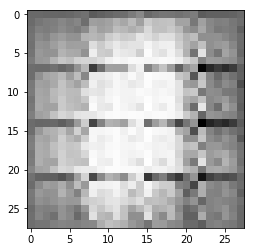

Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 2.0687


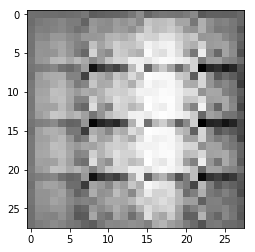

Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 3.7139


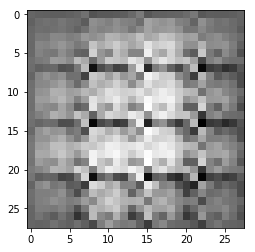

Epoch 1/2... Discriminator Loss: 0.2989... Generator Loss: 2.6772


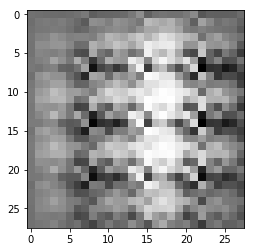

Epoch 1/2... Discriminator Loss: 0.4618... Generator Loss: 1.4195


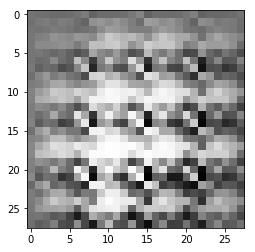

Epoch 1/2... Discriminator Loss: 0.2746... Generator Loss: 4.6941


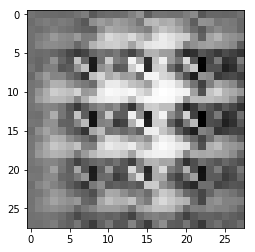

Epoch 1/2... Discriminator Loss: 0.2483... Generator Loss: 2.4109


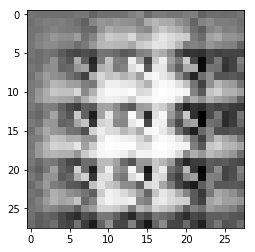

Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 0.6984


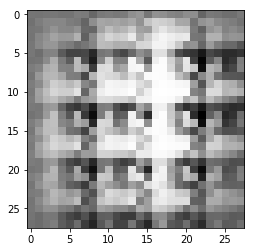

Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 10.2913


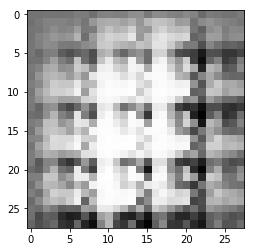

Epoch 1/2... Discriminator Loss: 0.1796... Generator Loss: 4.3153


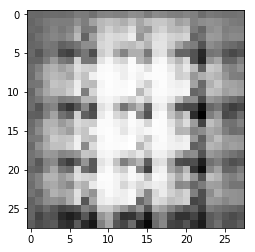

Epoch 1/2... Discriminator Loss: 3.3418... Generator Loss: 0.0666


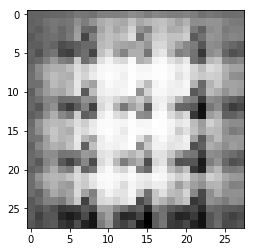

Epoch 1/2... Discriminator Loss: 2.5543... Generator Loss: 12.3600


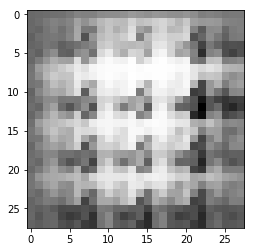

Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 8.5956


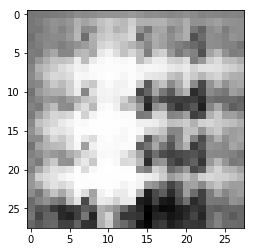

Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.5420


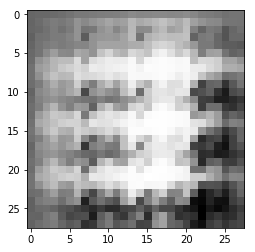

Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.4803


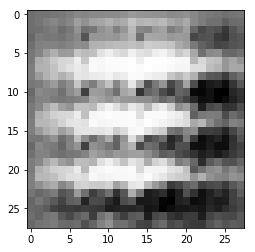

Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 7.0547


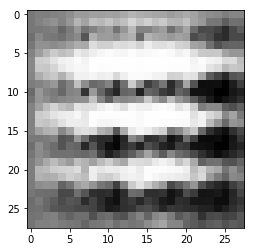

Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 5.4782


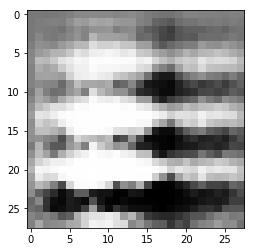

Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.0288


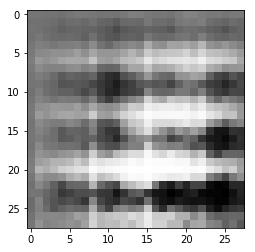

Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 3.8689


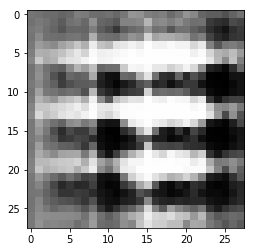

Epoch 1/2... Discriminator Loss: 0.2866... Generator Loss: 2.3665


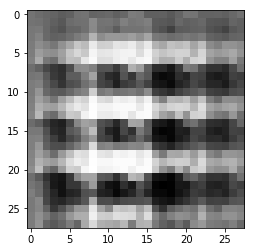

Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.0275


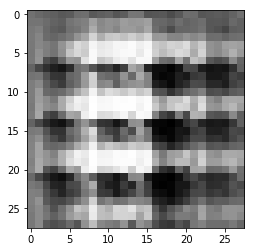

Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 4.4354


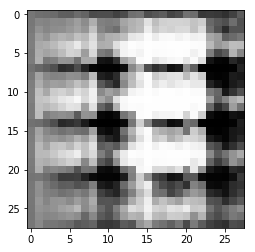

Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 0.9313


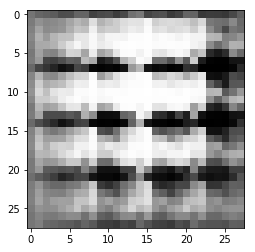

Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 5.8112


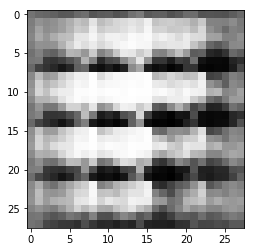

Epoch 1/2... Discriminator Loss: 0.2390... Generator Loss: 2.6139


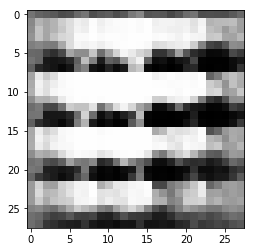

Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 1.1897


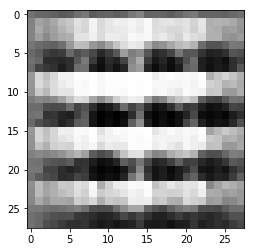

Epoch 1/2... Discriminator Loss: 0.1907... Generator Loss: 8.9565


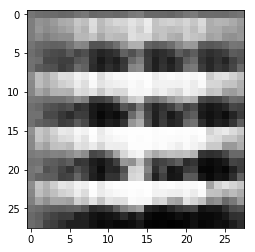

Epoch 1/2... Discriminator Loss: 0.1522... Generator Loss: 10.9731


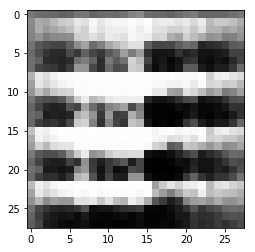

Epoch 1/2... Discriminator Loss: 0.1322... Generator Loss: 9.5109


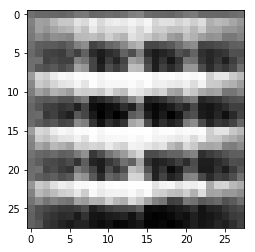

Epoch 1/2... Discriminator Loss: 0.0433... Generator Loss: 6.1081


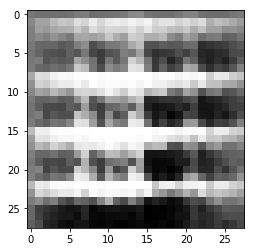

Epoch 1/2... Discriminator Loss: 0.3288... Generator Loss: 1.7773


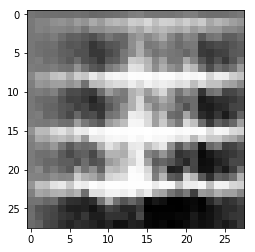

Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 2.5900


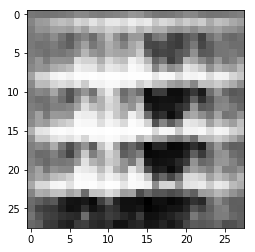

Epoch 1/2... Discriminator Loss: 0.2957... Generator Loss: 2.3417


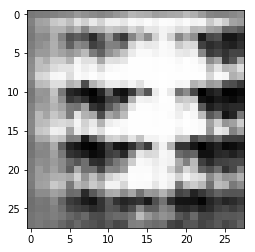

Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 3.3793


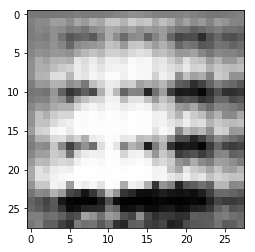

Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 2.2677


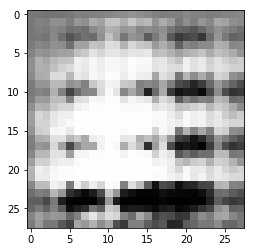

Epoch 1/2... Discriminator Loss: 0.1462... Generator Loss: 2.7659


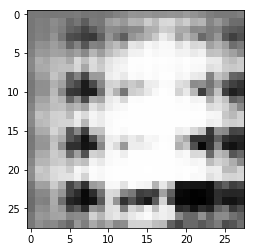

Epoch 1/2... Discriminator Loss: 0.0881... Generator Loss: 3.4155


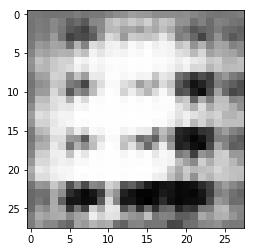

Epoch 1/2... Discriminator Loss: 0.1363... Generator Loss: 2.8121


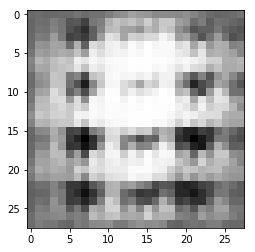

Epoch 1/2... Discriminator Loss: 0.2179... Generator Loss: 2.2943


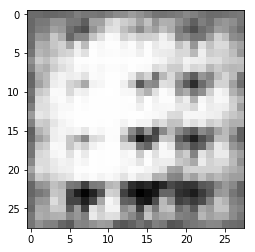

Epoch 1/2... Discriminator Loss: 0.1160... Generator Loss: 3.3574


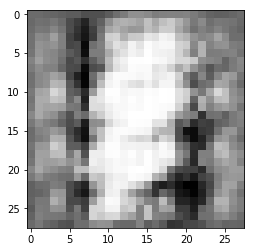

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.